In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import LFPy
import neuron
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import csv

In [3]:
#neuron.h.load_file('morphologies/L5_Mainen96_LFPy.hoc')  # a morphology file
#neuron.h.topology()
#for sec in h.allsec():
#    if 'apic' in str(sec):
#        sec.v = 0
#ps = neuron.h.PlotShape(True)
#ps.show(0)
#ps = neuron.h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
#ps.plot(plt)

In [4]:
cellParameters=[]
cellParameters.append ( {
    'morphology' : 'morphologies/L5_Mainen96_LFPy.hoc',
    'cm' : 1.0,                 # membrane capacitance
    'Ra' : 150,                 # axial resistance
    'v_init' : -65,             # initial crossmembrane potential
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 500,           # segments are isopotential at this frequency
    'tstart' : 0.0,
    'tstop' : 200.0,
    'dt' : 2**-5,
    'passive' : True,
} )

cellParameters.append ( {
    'morphology' : 'morphologies/j4a.hoc',
    'cm' : 1.0,                 # membrane capacitance
    'Ra' : 150,                 # axial resistance
    'v_init' : -65,             # initial crossmembrane potential
    'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, # passive params
    'nsegs_method' : 'lambda_f',# method for setting number of segments,
    'lambda_f' : 500,           # segments are isopotential at this frequency
    'tstart' : 0.0,
    'tstop' : 200.0,
    'dt' : 2**-5,
    'passive' : True,
} )

#print(cellParameters[1])

In [5]:
synapseParameters = {
    'idx' : 0,               # insert synapse on index "0", the soma
    'e' : 0.,                # reversal potential of synapse
    'syntype' : 'Exp2Syn',   # conductance based double-exponential synapse
    'tau1' : 5.0,            # Time constant, rise
    'tau2' : 3.0,            # Time constant, decay
    'weight' : 0.1,         # Synaptic weight
    'record_current' : True, # Will enable synapse current recording
}

In [6]:
np.random.seed(1676)
shift_x=np.random.uniform(-150.,150.,10)

np.random.seed(14)
shift_y=np.random.uniform(-25.,25.,10)

np.random.seed(251)
shift_z=np.random.uniform(-150.,150.,10)

np.random.seed(511)
randParameters=np.random.choice(cellParameters,size=10)

colors=[]
np.random.seed(562)
for i in range(10):
    colors.append(tuple(np.random.rand(3))+(0.5,))

shift_x[0]=0.0
shift_y[0]=0.0
shift_z[0]=0.0

spike_time=[
    np.array([12.0,70.0]),
    np.array([20.0,95.0]),
    np.array([55.0,145.0]),
    np.array([11.0,45.0,90.0,130.0]),
    np.array([30.0,80.0]),
    np.array([115.0,160.0]),
    np.array([15.0,56.0,100.0]),
    np.array([21.0,49.0]),
    np.array([65.0,125.0]),
    np.array([45.0,127.0]),
]
#print(shift_x)
#print(shift_y)
#print(shift_z)
#print(randParameters)
#print(colors)
#for x, y, z in zip(shift_x, shift_y, shift_z):
#    print(x, y, z)
#print(spike_time)

In [7]:
def set_cell(i):
    #delete cell instances from previous script executions,
    neuron.h('forall delete_section()')

    cell = LFPy.Cell(**randParameters[i])
    cell.set_pos(x=shift_x[i], y=shift_y[i], z=shift_z[i])
    synapse = LFPy.Synapse(cell, **synapseParameters)
    synapse.set_spike_times(spike_time[i])
    return cell, synapse

In [8]:
lattice_constance = 50.0
u_0 = (lattice_constance, 0.0)
u_1 = (0.5*lattice_constance, 0.5*np.sqrt(3.0)*lattice_constance)
id=0
x=np.zeros(7*7*3)
y=np.zeros(7*7*3)
z=np.zeros(7*7*3)
for j in range(-1, 2):
    for k in range(-3, 4):
        for i in range(-5, 6):
            #print(i,j,k)
            x_test=u_0[0]*i+u_1[0]*k
            if(x_test>-155.0 and x_test<155.0):
                x[id]=x_test
                y[id]=lattice_constance*j
                z[id]=u_0[1]*i+u_1[1]*k
                id += 1          
            else:
                #print("truncated")
                pass

# define parameters for extracellular recording electrode, using optional method    
electrodeParameters = {
    'x' : x,
    'y' : y,
    'z' : z,
    'sigma' : 0.3,
#    'method' : 'soma_as_point',  #treat soma segment as sphere source
}

electrode = LFPy.RecExtElectrode(**electrodeParameters)

In [9]:
cell, synapse = set_cell(9)
cell.simulate(electrode = electrode)

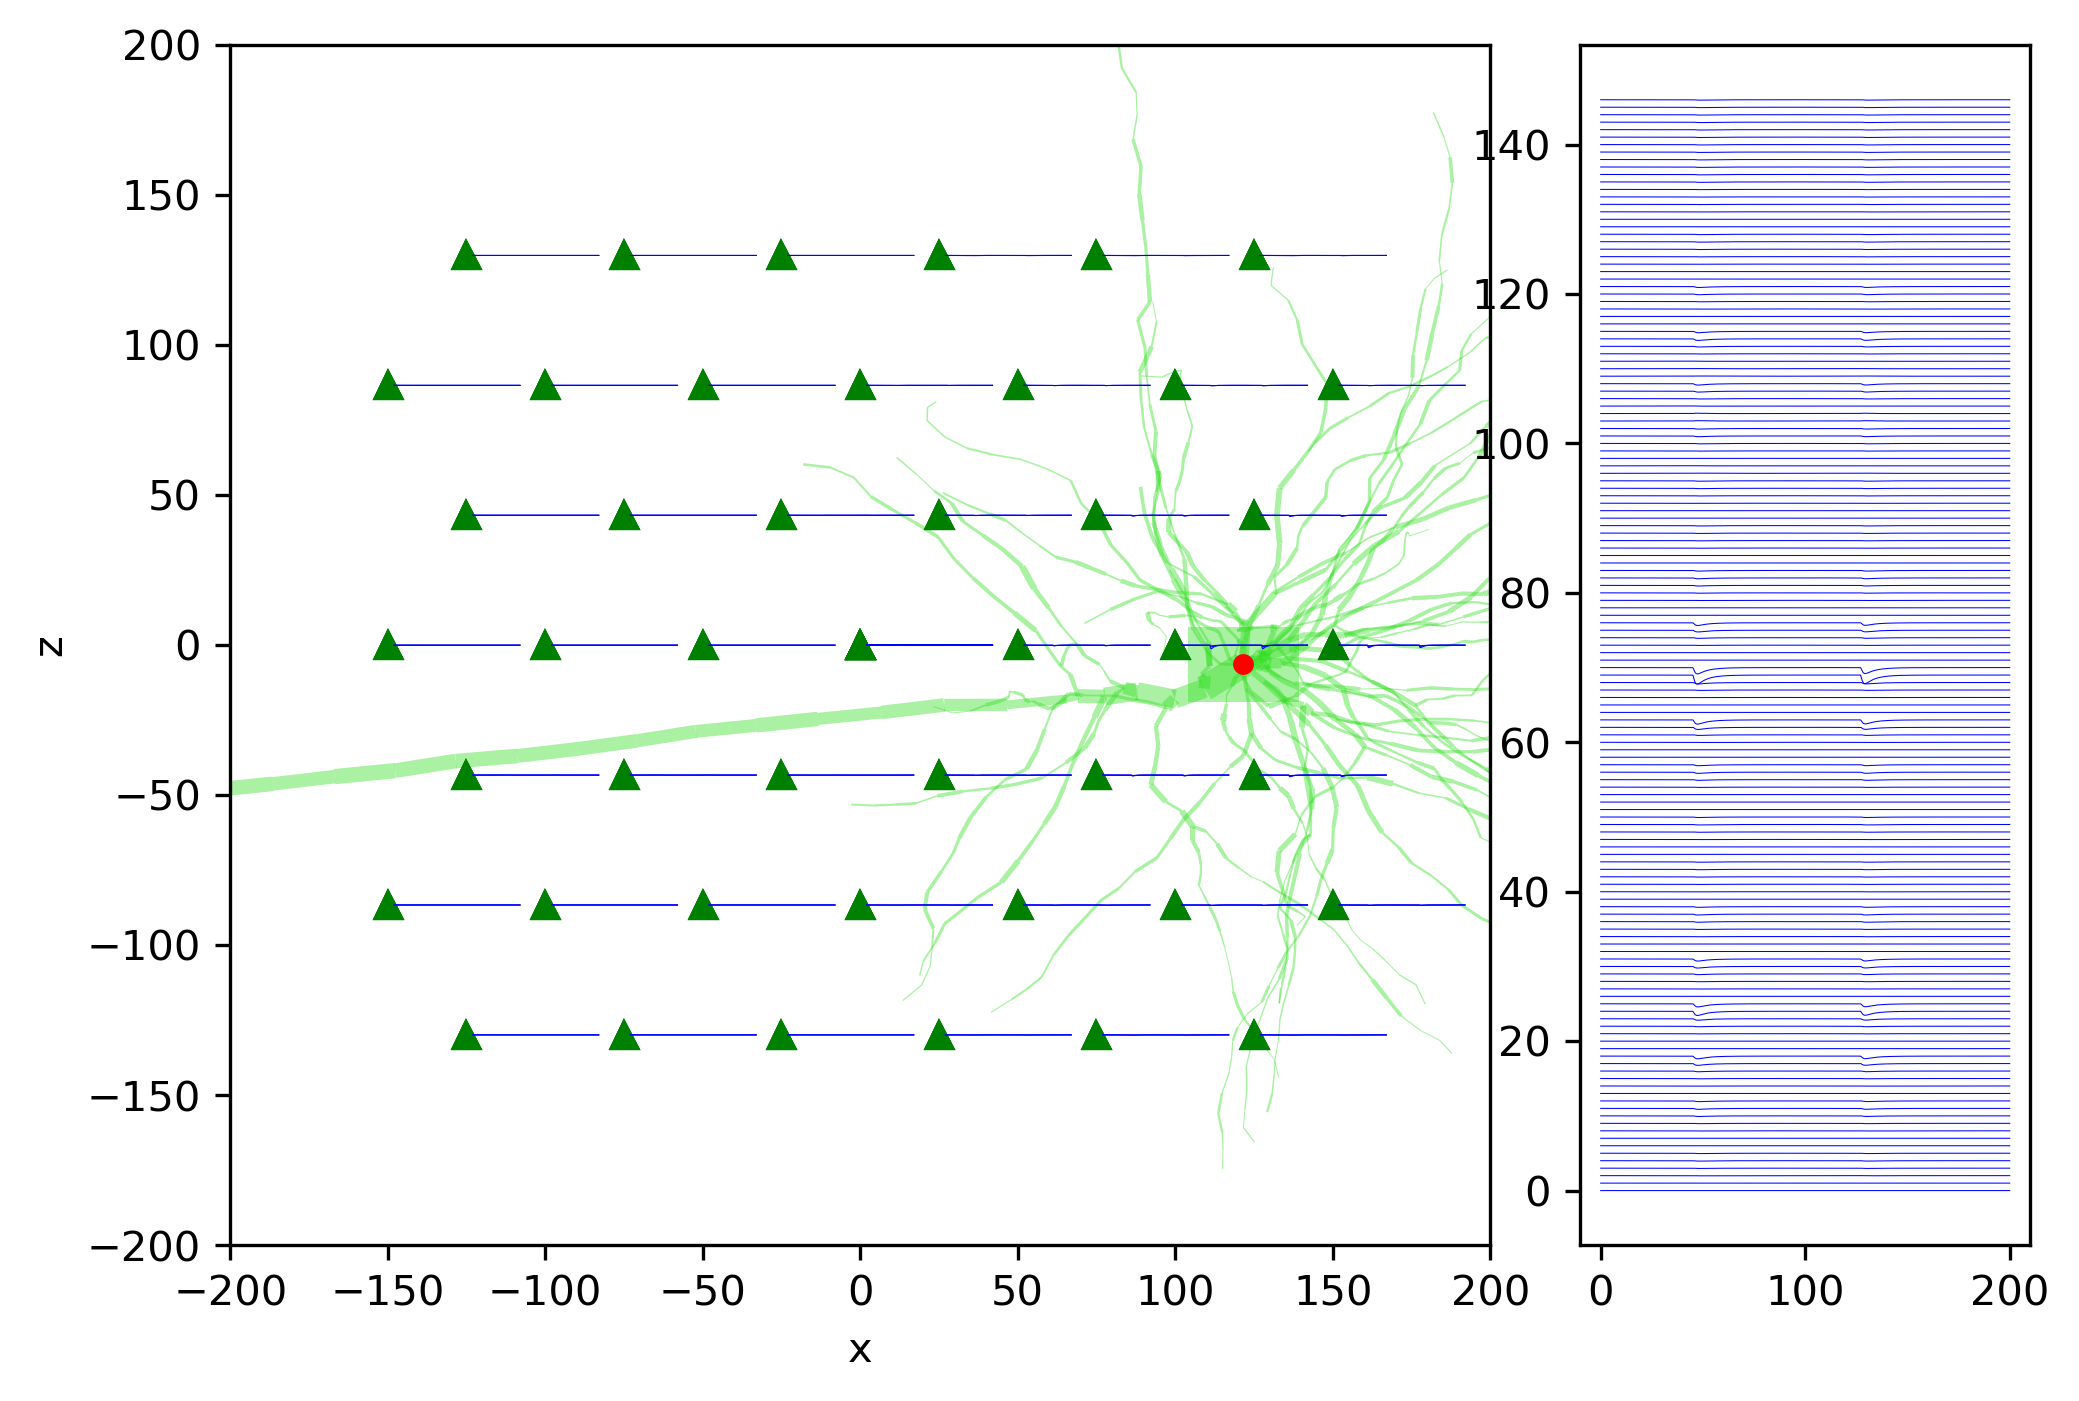

In [34]:
fig = plt.figure(dpi=300)

ax = fig.add_axes([0.0,0.0,0.7,1.0], frameon=True)
ax.set_xlabel('x')
ax.set_ylabel('z')
#plot electrode
ax.plot(electrode.x, electrode.z,'.', marker='^', color='g')

i = 0
limLFP = abs(electrode.LFP).max()
for LFP in electrode.LFP:
    tvec = cell.tvec*0.2 + electrode.x[i] + 2
    if abs(LFP).max() >= 1:
        factor = 2
        color='r'
    elif abs(LFP).max() < 0.25:
        factor = 50
        color = 'b'
    else:
        factor = 10
        color = 'g'
    trace = LFP*factor + electrode.z[i]
    ax.plot(tvec, trace, color=color, lw = 0.25)
    i += 1

#plot cell morphology
zips = []
for x, z in cell.get_idx_polygons():
    zips.append(list(zip(x, z)))

polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors=colors[9], alpha=0.4)
ax.add_collection(polycol)

#ax.plot([100, 200], [-400, -400], 'k', lw=1, clip_on=False)
#ax.text(150, -470, r'100$\mu$m', va='center', ha='center')

ax.axis('on')
ax.axis([-200., 200., -200., 200.])

#plot Synapse
ax.plot(cell.xmid[cell.synidx],cell.zmid[cell.synidx], 'o', ms=5,
        markeredgecolor='none',
        markerfacecolor='r')

ax = fig.add_axes([0.75, 0.0, 0.25, 1.0])
i = 0
limLFP = abs(electrode.LFP).max()
for LFP in electrode.LFP:
    tvec = cell.tvec
    if abs(LFP).max() >= 1:
        factor = 2
        color='r'
    elif abs(LFP).max() < 0.25:
        factor = 50
        color = 'b'
    else:
        factor = 10
        color = 'g'
    trace = LFP*factor + i
    ax.plot(cell.tvec, trace, color=color, lw = 0.25)
    i += 1

In [11]:
table = np.vstack( (cell.tvec,electrode.LFP) )
with open('cell_9.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(table.T)
print(cell.tvec.shape, electrode.LFP.shape, table.shape)

(6401,) (147, 6401) (148, 6401)


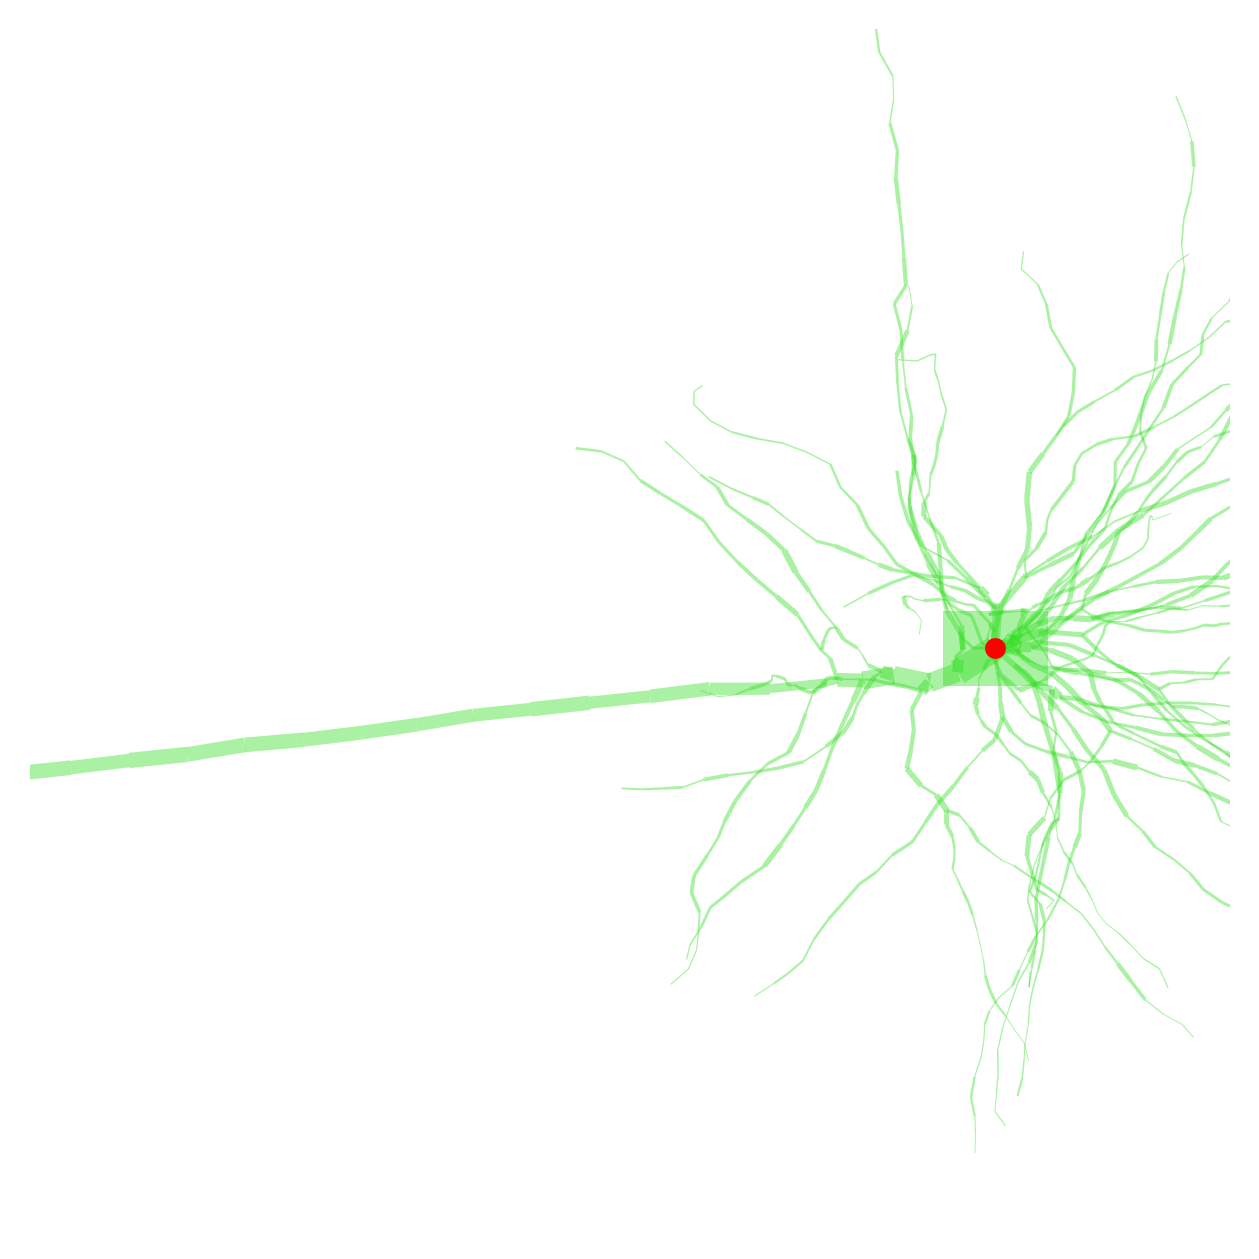

In [12]:
fig = plt.figure(dpi=300)

ax = fig.add_axes([0.0,0.0,1.0,1.0], aspect='equal', frameon=False)

#plot electrode
#ax.plot(electrode.x, electrode.z,'.', marker='^', color='g')
#plot cell morphology
zips = []
for x, z in cell.get_idx_polygons():
    zips.append(list(zip(x, z)))

polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors=colors[9], alpha=0.4)
ax.add_collection(polycol)

#ax.plot([100, 200], [-400, -400], 'k', lw=1, clip_on=False)
#ax.text(150, -470, r'100$\mu$m', va='center', ha='center')

ax.axis('off')
ax.axis([-200., 200., -200., 200.])

#plot Synapse
ax.plot(cell.xmid[cell.synidx],cell.zmid[cell.synidx], 'o', ms=5,
        markeredgecolor='none',
        markerfacecolor='r')

In [13]:
def plot_cube(cube_definition):
    #four points of a cube, a corner first, and then the three adjacent points to that corner.
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    fig = plt.figure(dpi=300)
    ax = fig.add_axes([0.0,0.0,1.0,1.0], projection='3d')

    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k', alpha=0.2)
    faces.set_facecolor((0,0,1,0.1))

    ax.add_collection3d(faces)

    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)

    #ax.set_aspect('equal')

In [20]:
# draw cube
def rect_prism(x_range, y_range, z_range):
    # TODO: refactor this to use an iterator
    xx, yy = np.meshgrid(x_range, y_range)
    zz = z_range[0]*np.ones(xx.shape)
    ax.plot_wireframe(xx, yy, zz, color="r")
    ax.plot_surface(xx, yy, zz, color="r", alpha=0.2)
    zz = z_range[1]*np.ones(xx.shape)
    ax.plot_wireframe(xx, yy, zz, color="r")
    ax.plot_surface(xx, yy, zz, color="r", alpha=0.2)

    yy, zz = np.meshgrid(y_range, z_range)
    xx = x_range[0]*np.ones(yy.shape)
    ax.plot_wireframe(xx, yy, zz, color="r")
    ax.plot_surface(xx, yy, zz, color="r", alpha=0.2)
    xx = x_range[1]*np.ones(yy.shape)
    ax.plot_wireframe(xx, yy, zz, color="r")
    ax.plot_surface(xx, yy, zz, color="r", alpha=0.2)

    xx, zz = np.meshgrid(x_range, z_range)
    yy = y_range[0]*np.ones(zz.shape)
    ax.plot_wireframe(xx, yy, zz, color="r")
    ax.plot_surface(xx, yy, zz, color="r", alpha=0.2)
    yy = y_range[1]*np.ones(zz.shape)
    ax.plot_wireframe(xx, yy, zz, color="r")
    ax.plot_surface(xx, yy, zz, color="r", alpha=0.2)

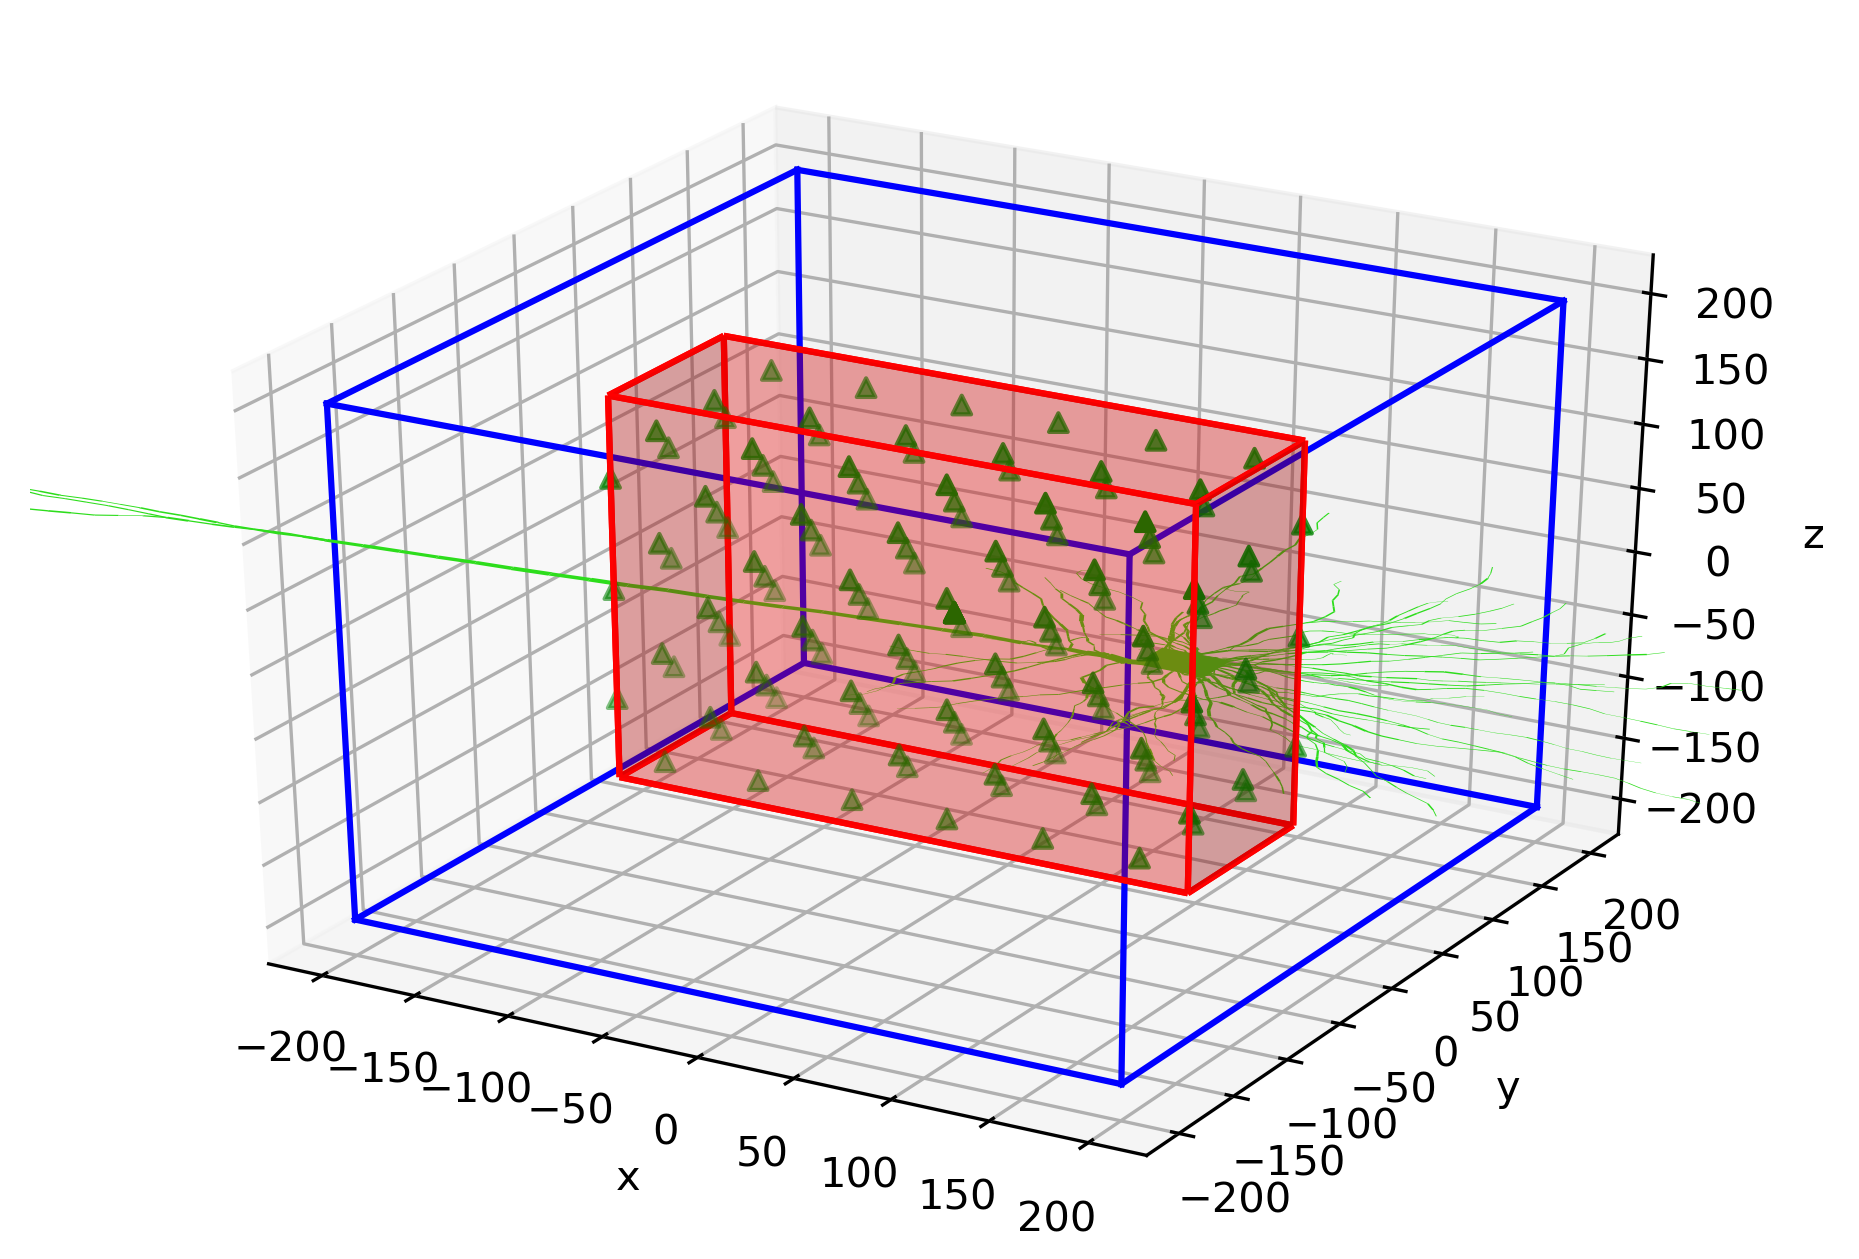

In [36]:
fig = plt.figure(dpi=300)
ax = fig.add_axes([0.0,0.0,1.0,1.0], projection='3d')
ax.scatter(electrode.x, electrode.y, electrode.z,'.', marker='^', color='g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

from itertools import product, combinations
r = [-200, 200]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="b")
        
rect_prism( np.array([-150, 150]), np.array([-50, 50]), np.array([-150, 150]) )

#plot cell morphology
zips = []
for x, z in cell.get_idx_polygons():
    zips.append(list(zip(x, z)))

polycol = PolyCollection(zips,
                         edgecolors='none',
                         facecolors=colors[9], alpha=1.0)
ax.add_collection3d(polycol)

#ax.view_init(elev=0,azim=90)

#ps = neuron.h.PlotShape(False)  # False tells h.PlotShape not to use NEURON's gui
#ps.plot(plt)


In [35]:
cube_definition = [
    (-200,-200,-50), (-200,200,-50), (200,-200,-50), (-200,-200,50)
]

#plot_cube(cube_definition)

In [17]:
scatters = []
scatters.append(go.Scatter3d(
              x=electrode.x,
              y=electrode.y,
              z=electrode.z,
              mode='markers',
              marker=dict(
                          symbol='diamond',
                          size=2,
                          color=y,                # set color to an array/list of desired values
                          colorscale='Viridis',   # choose a colorscale
                          opacity=0.5
                         )
              ))

lines = []
line_marker = dict(color='#0066FF', width=2)

faces=[]

x_range, y_range, z_range = np.array([-200, 200]), np.array([-200, 200]), np.array([-200, 200])
x_crop, y_crop, z_crop = np.array([-150, 150]), np.array([-50, 50]), np.array([-150, 150])

xx, yy = np.meshgrid(x_range, y_range)
zz = z_range[0]*np.ones(xx.shape)
for i, j, k in zip(xx, yy, zz):
    lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker))
    lines.append(go.Scatter3d(x=i, y=j, z=-k, mode='lines', line=line_marker))

xxx, yyy = np.meshgrid(x_crop, y_crop)
zzz = z_crop[0]*np.ones(xxx.shape)
faces.append(go.Surface(x = xxx, y = yyy, z = zzz, showscale=False, opacity=0.3))
faces.append(go.Surface(x = xxx, y = yyy, z =-zzz, showscale=False, opacity=0.3))
    
yy, zz = np.meshgrid(y_range, z_range)
xx = x_range[0]*np.ones(yy.shape)
for i, j, k in zip(xx, yy, zz):
    lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker))
    lines.append(go.Scatter3d(x=-i, y=j, z=k, mode='lines', line=line_marker))

yyy, zzz = np.meshgrid(y_crop, z_crop)
xxx = x_crop[0]*np.ones(yyy.shape)
faces.append(go.Surface(x = xxx, y = yyy, z = zzz, showscale=False, opacity=0.3))
faces.append(go.Surface(x =-xxx, y = yyy, z = zzz, showscale=False, opacity=0.3))

zz, xx = np.meshgrid(z_range, x_range)
yy = y_range[0]*np.ones(zz.shape)
for i, j, k in zip(xx, yy, zz):
    lines.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker))
    lines.append(go.Scatter3d(x=i, y=-j, z=k, mode='lines', line=line_marker))

zzz, xxx = np.meshgrid(z_crop, x_crop)
yyy = y_crop[0]*np.ones(zzz.shape)
faces.append(go.Surface(x = xxx, y = yyy, z = zzz, showscale=False, opacity=0.3))
faces.append(go.Surface(x = xxx, y =-yyy, z = zzz, showscale=False, opacity=0.3))

fig = go.Figure(data=scatters+lines+faces)

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=10, range=[-200,200],),
        yaxis = dict(nticks=10, range=[-200,200],),
        zaxis = dict(nticks=10, range=[-200,200],),
    ),
    scene_aspectmode='cube'
)

fig.show()